Before setting out to explore this data I will state a few questions that I would like to answer:
    1. What variables (Home Runs, Walks, Strike Outs, Errors, etc.) have the strongest correlation with success (winning percentage)?
    2. What is the cost (player salaries) of improving on these important factors?

Import relevant data

In [109]:
import pandas as pd
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

batting_all_df = pd.read_csv('Batting.csv')
teams_all_df = pd.read_csv('Teams.csv')
pitching_all_df = pd.read_csv('Pitching.csv')
fielding_all_df = pd.read_csv('Fielding.csv')
salaries_all_df = pd.read_csv('Salaries.csv')


Populating the interactive namespace from numpy and matplotlib


Define procedure to measure correlation between 2 variables

In [110]:
def correlation(x, y):
    x_avg = x.mean()
    y_avg = y.mean()
    x_stdz = (x - x_avg)/x.std(ddof=0)
    y_stdz = (y - y_avg)/y.std(ddof=0)
    return (x_stdz * y_stdz).mean()

Define procedure to standardize a variable

In [111]:
def standardize(df):
    return (df - df.mean())/df.std(ddof=0)

Add column Winning Percentage to teams_df

In [112]:
teams_all_df['WP'] = teams_all_df['W']/(teams_all_df['W']+teams_all_df['L'])
teams_wp = teams_df['WP']


Look at histogram of the number of wins

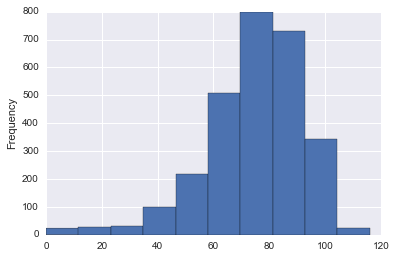

In [113]:
teams_all_df['W'].plot.hist()

It looks like this distribution is negatively skewed.  It occured to me that teams used to not play as many games.  

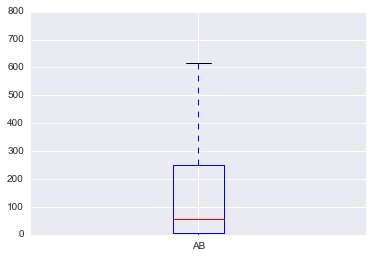

In [114]:
batting_all_df['AB'].plot.box()

It looks like the vast majority of players record very few at bats in a season. For the purposes of this analysis, we will want to look at starters/frequent players.  Below I will exclude players with less than 200 at bats from the analysis

In [115]:
batting_all_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13,8,1,4,0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19,3,1,2,5,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27,1,1,0,2,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16,6,2,2,1,NaN,NaN,NaN,NaN,NaN


Just by looking at the first five rows of this data set, I can tell there will be a lot of missing values.  I will not make any adjustments for missing values below.  By leaving the NaN's in the data, I will omit them from the analysis.  This is an imperfect method, because some records will be partial. For instance, a player may have NaN for 'HBP' in the batter data, but have records for other variables, like 'H'. This will mean their 'H' may be included in some of the analysis, while any metric using 'HBP' will be excluded.

Get just the data from 1985 on because there is no salary data before then, and to exclude older seasons where not as many games were played.

In [116]:

teams_df = teams_all_df[teams_all_df['yearID']>=1985]


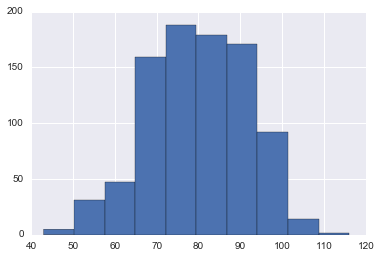

In [117]:
teams_df['W'].hist()

It surpises me that there are still teams with less than 50 wins.  Let's look at these records to see if something is going on.

In [118]:
low_win_total = teams_df[teams_df['W']<=50]
low_win_total

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,WP
2156,1994,AL,CAL,ANA,W,4,115,63,47,68,...,0.980,California Angels,Anaheim Stadium,1512622,101,101,CAL,CAL,CAL,0.408696
2158,1994,NL,CHN,CHC,C,5,113,59,49,64,...,0.980,Chicago Cubs,Wrigley Field,1845208,99,99,CHC,CHN,CHN,0.433628
2175,1994,NL,SDN,SDP,W,4,117,57,47,70,...,0.970,San Diego Padres,Jack Murphy Stadium,953857,97,98,SDP,SDN,SDN,0.401709
2176,1994,AL,SEA,SEA,W,3,112,44,49,63,...,0.970,Seattle Mariners,Kingdome,1104206,102,102,SEA,SEA,SEA,0.437500
2425,2003,AL,DET,DET,C,5,162,81,43,119,...,0.978,Detroit Tigers,Comerica Park,1368245,93,95,DET,DET,DET,0.265432


4 of the 5 records are from the 1994 season.  A quick google search reminded me that this year was cut short due to a strike: https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike  
I'm going to remove this season from the analysis below.

In [119]:
teams_df = teams_df[teams_df['yearID']!=1994]
teams_df

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,WP
1917,1985,NL,ATL,ATL,W,5,162,81,66,96,...,0.970,Atlanta Braves,Atlanta-Fulton County Stadium,1350137,105,106,ATL,ATL,ATL,0.407407
1918,1985,AL,BAL,BAL,E,4,161,81,83,78,...,0.980,Baltimore Orioles,Memorial Stadium,2132387,97,97,BAL,BAL,BAL,0.515528
1919,1985,AL,BOS,BOS,E,5,163,81,81,81,...,0.970,Boston Red Sox,Fenway Park II,1786633,104,104,BOS,BOS,BOS,0.500000
1920,1985,AL,CAL,ANA,W,2,162,79,90,72,...,0.980,California Angels,Anaheim Stadium,2567427,100,100,CAL,CAL,CAL,0.555556
1921,1985,AL,CHA,CHW,W,3,163,81,85,77,...,0.980,Chicago White Sox,Comiskey Park,1669888,104,104,CHW,CHA,CHA,0.524691
1922,1985,NL,CHN,CHC,E,4,162,81,77,84,...,0.970,Chicago Cubs,Wrigley Field,2161534,110,110,CHC,CHN,CHN,0.478261
1923,1985,NL,CIN,CIN,W,2,162,81,89,72,...,0.980,Cincinnati Reds,Riverfront Stadium,1834619,104,105,CIN,CIN,CIN,0.552795
1924,1985,AL,CLE,CLE,E,7,162,81,60,102,...,0.970,Cleveland Indians,Cleveland Stadium,655181,99,100,CLE,CLE,CLE,0.370370
1925,1985,AL,DET,DET,E,3,161,81,84,77,...,0.970,Detroit Tigers,Tiger Stadium,2286609,100,98,DET,DET,DET,0.521739
1926,1985,NL,HOU,HOU,W,3,162,81,83,79,...,0.970,Houston Astros,Astrodome,1184314,97,96,HOU,HOU,HOU,0.512346


Calculate correlation between winning percentage and various offensive metrics on the team level

In [120]:
team_wp = teams_df['WP']

r_t = teams_df['R'] #runs; _t notes that this is a team calculation
hr_t = teams_df['HR'] #homeruns
so_t = teams_df['SO'] #strike outs
bb_t = teams_df['BB'] #walks
h_t= teams_df['H'] #hits
sb_t = teams_df['SB'] #stolen bases
doubles_t = teams_df['2B'] 
triples_t = teams_df['3B']
singles_t = h_t - hr_t - doubles_t - triples_t
ab_t = teams_df['AB'] # at bats
hbp_t = teams_df['HBP'] #hit by pitch
ba_t = h_t/ab_t #batting average
sf_t = teams_df['SF'] #sacrifice fly
obp_t = (h_t + bb_t + hbp_t)/(ab_t + bb_t + hbp_t + sf_t) #on base percentage
sp_t = (singles_t+(doubles_t*2)+(triples_t*3)+(hr_t*4))/ab_t #slugging percentage
ops_t = obp_t+sp_t #on base percentage plus slugging percentage



In [121]:
print 'Team Winning Percentage correlation with:'
print 'runs', correlation(team_wp,r_t)
print 'homeruns', correlation(team_wp,hr_t)
print 'strikeouts', correlation(team_wp,so_t)
print 'walks', correlation(team_wp,bb_t)
print 'stolen bases', correlation(team_wp,sb_t)
print 'doubles', correlation(team_wp,doubles_t)
print 'triples', correlation(team_wp,triples_t)
print 'batting average', correlation(team_wp,ba_t)
print 'on base percentage', correlation(team_wp,obp_t)
print 'slugging percentage', correlation(team_wp,sp_t)
print 'OPS', correlation(team_wp,ops_t)


Team Winning Percentage correlation with:
runs 0.493626993361
homeruns 0.322638849761
strikeouts -0.0998356129231
walks 0.396784916734
stolen bases 0.105526125012
doubles 0.207103719273
triples -0.0123341547813
batting average 0.37223103404
on base percentage 0.497352222237
slugging percentage 0.400993970215
OPS 0.499892307288


Calculate correlation between winning percentage and various defensive/pitching metrics on the team level

In [122]:
ra_t = teams_df['RA'] #runs against
era_t = teams_df['ERA'] #earned run average
e_t = teams_df['E'] #errors
fp_t = teams_df['FP'] #fielding percentage
ha_t = teams_df['HA'] #hits against
soa_t = teams_df['SOA'] #strike outs against
bba_t = teams_df['BBA'] #walks against
cg_t = teams_df['CG'] #complete games




In [123]:
print 'Team Winning Percentage correlation with:'
print 'runs against', correlation(team_wp,ra_t)
print 'ERA', correlation(team_wp,era_t)
print 'errors', correlation(team_wp,e_t)
print 'fielding percentage', correlation(team_wp,fp_t)
print 'hits against', correlation(team_wp,ha_t)
print 'strikeouts against', correlation(team_wp,soa_t)
print 'walks against', correlation(team_wp,bba_t)
print 'complete games', correlation(team_wp,cg_t)


Team Winning Percentage correlation with:
runs against -0.574289771373
ERA -0.557749195526
errors -0.291138945424
fielding percentage 0.208124401264
hits against -0.465033403267
strikeouts against 0.268556165251
walks against -0.388669611323
complete games 0.0970773596518


OPS, on base percentage, runs, runs against, and era have the strongest correlation to winning percentage for the variables tested.  This makes intuitive sense because a team that scores more runs than they give up wins.  

Let's take a deeper dive into offense, particularly what may be an indicator for runs.  I want to see which variables have the strongest correlation with runs.  Then I want to look at salary data to see if the same variables that are correlated with runs are correlated with salaries. 

In [124]:
print 'Runs scored correlation with:'
print 'homeruns', correlation(r_t,hr_t)
print 'doubles', correlation(r_t,doubles_t)
print 'triples', correlation(r_t,triples_t)
print 'stolen bases', correlation(r_t,sb_t)
print 'walks', correlation(r_t,bb_t)
print 'strikeouts', correlation(r_t,so_t)
print 'batting average', correlation(r_t,ba_t)
print 'on base percentage', correlation(r_t,obp_t)
print 'slugging percentage', correlation(r_t,sp_t)
print 'OPS', correlation(r_t,ops_t)

#create panda series for visualization below

runs_correlates = pd.Series([correlation(r_t,hr_t),correlation(r_t,doubles_t),correlation(r_t,triples_t),correlation(r_t,sb_t),correlation(r_t,bb_t),correlation(r_t,so_t),correlation(r_t,ba_t),correlation(r_t,obp_t),correlation(r_t,sp_t),correlation(r_t,ops_t)], index = ['hr','2b','3b','sb','bb','so','ba','obp','sp','ops'])

Runs scored correlation with:
homeruns 0.726674621669
doubles 0.598712159562
triples 0.018031160213
stolen bases -0.04911416873
walks 0.588183268638
strikeouts -0.078266132659
batting average 0.809210185909
on base percentage 0.881337023236
slugging percentage 0.892841521988
OPS 0.93842522203


OPS, which encapsulates how often a team/player gets on base and how man bases they get per attempt, has the strongest correlation to runs.  It it possible that this doesn't mean OPS is the most important statistic listed above for scoring runs.  It is my opinion that it probably is since the factors it measures are factors you would expect to matter for scoring runs.

Prepare player data from 1985 through 2015.

In [125]:
#add 1 to all count stats below to adjust for zeros
ab_p = batting_all_df['AB'] + 1 #at bats; _p denotes player
r_p = batting_all_df['R'] + 1 
h_p = batting_all_df['H'] + 1
hr_p = batting_all_df['HR'] + 1 #homeruns
batting_all_df['HR/AB']=batting_all_df['HR']/batting_all_df['AB']
triples_p = batting_all_df['3B'] + 1
doubles_p = batting_all_df['2B'] + 1
rbi_p = batting_all_df['RBI'] + 1
sb_p = batting_all_df['SB'] + 1
bb_p = batting_all_df['BB'] + 1
so_p = batting_all_df['SO'] + 1
ibb_p = batting_all_df['IBB'] + 1
hbp_p = batting_all_df['HBP'] + 1
sf_p = batting_all_df['SF'] + 1
singles_p = batting_all_df['H'] - hr_p - triples_p - doubles_p + 1
ba_p = h_p/ab_p
obp_p = (h_p + bb_p + hbp_p)/(ab_p + bb_p + hbp_p + sf_p) #on base percentage
sp_p = (singles_p+(doubles_p*2)+(triples_p*3)+(hr_p*4))/ab_p #slugging percentage
batting_all_df['OPS'] = obp_p+sp_p
ops_p = batting_all_df['OPS']



In [126]:
#data from 1985 on because no salary data before 1985 
batting_df = batting_all_df[batting_all_df['yearID']>=1985]
pitching_df = pitching_all_df[pitching_all_df['yearID']>=1985]
fielding_df = fielding_all_df[fielding_all_df['yearID']>=1985]
salaries_df = salaries_all_df[salaries_all_df['yearID']>=1985]
#remove 1994 season
batting_df = batting_df[batting_df['yearID']!=1994]
pitching_df = pitching_df[pitching_df['yearID']!=1994]
fielding_df = fielding_df[fielding_df['yearID']!=1994]
salaries_df = salaries_df[salaries_df['yearID']!=1994]

Merge batting and salaries dfs (batting_salaries).  Create bat_sal_everyday to drop players who get less than 200 at bats in the season out of the data.  The goal is to look at everyday players, so this should partially correct for players injured most of the year and players called up for a short time.

In [127]:

batting_salaries = batting_df.merge(salaries_df,on=['yearID','playerID'],how='inner') 
bat_sal_everyday = batting_salaries[batting_salaries['AB']>=200] 
len(bat_sal_everyday)

8698

In [128]:
salary_p = bat_sal_everyday['salary'] # player salary




Let's calculate player salaries to the same offensive statistics above, except at the player level.  If teams are being rational we should expect the strongest correlates to runs at the team level to be the highest correlates to player salaries at the player level (all else being equal).

In [129]:
print 'Correlation with player salaries:'
print 'homeruns', correlation(salary_p,hr_p)
print 'doubles', correlation(salary_p,doubles_p)
print 'triples', correlation(salary_p,triples_p)
print 'stolen bases', correlation(salary_p,sb_p)
print 'walks', correlation(salary_p,bb_p)
print 'strikouts', correlation(salary_p,so_p)
print 'batting average', correlation(salary_p,ba_p)
print 'on base percentage', correlation(salary_p,obp_p)
print 'slugging percentage', correlation(salary_p,sp_p)
print 'OPS', correlation(salary_p,ops_p)


Correlation with player salaries:
homeruns 0.0220263029942
doubles 0.0203310760845
triples -0.0357236458744
stolen bases -0.0872175611889
walks 0.00946098600467
strikouts -0.0282768937315
batting average 0.0339932372119
on base percentage 0.477161294132
slugging percentage 0.025108086592
OPS 0.551264863355


It has occured to me that salaries have likely risen sharply since 1985 levels which may cause problems with my analysis.  Let's investigate:

<Container object of 30 artists>

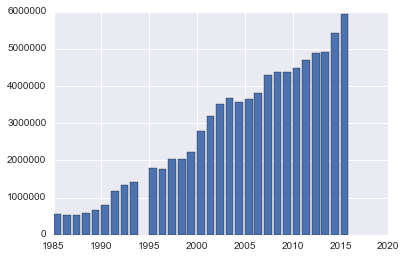

In [130]:
bat_sal_yr_grp = bat_sal_everyday.groupby('yearID',as_index=False).mean()


plt.bar(bat_sal_yr_grp['yearID'],bat_sal_yr_grp['salary']) 
#returns bar plot of average salary per year

Salaries have risen sharply as I thought.  Let's adjust these salaries back to 1985 levels for comparison purposes.

In [131]:
#adjust salaries to 1985 levels to better compare across time

salary = bat_sal_yr_grp['salary'] # player salary
bat_sal_yr_grp['CPI'] = salary/salary[0] #calculate cpi for player salaries
cpi = bat_sal_yr_grp['CPI']
bat_sal_yr_grp['sal_real'] = salary/cpi #adjust salaries to 1985 levels for comparisons



In [132]:
#create df with player data from 1985 on, including yearly averages and salary data set
#at 1985 levels for comparison purposes
bat_sal_everyday_df = pd.DataFrame(bat_sal_everyday)
bat_sal_everyday_df = bat_sal_everyday_df.merge(bat_sal_yr_grp,on=['yearID'],how='inner')
bat_sal_everyday_df['sal_real']=bat_sal_everyday_df['salary_x']/bat_sal_everyday_df['CPI']

bat_sal_everyday_df.head()

,playerID,yearID,stint_x,teamID_x,lgID_x,G_x,AB_x,R_x,H_x,2B_x,...,IBB_y,HBP_y,SH_y,SF_y,GIDP_y,HR/AB_y,OPS_y,salary_y,CPI,sal_real
0,almonbi01,1985,1,PIT,NL,88,244,33,66,17,...,4.559322,2.275424,2.961864,3.728814,10.576271,0.027472,0.757271,566013.025424,1,255000
1,armasto01,1985,1,BOS,AL,103,385,50,102,17,...,4.559322,2.275424,2.961864,3.728814,10.576271,0.027472,0.757271,566013.025424,1,915000
2,backmwa01,1985,1,NYN,NL,145,520,77,142,24,...,4.559322,2.275424,2.961864,3.728814,10.576271,0.027472,0.757271,566013.025424,1,200000
3,baineha01,1985,1,CHA,AL,160,640,86,198,29,...,4.559322,2.275424,2.961864,3.728814,10.576271,0.027472,0.757271,566013.025424,1,675000
4,bakerdu01,1985,1,OAK,AL,111,343,48,92,15,...,4.559322,2.275424,2.961864,3.728814,10.576271,0.027472,0.757271,566013.025424,1,575000


In [133]:
sal_real= bat_sal_everyday_df['sal_real']

#again, add 1 to compensate for zeros
ab = bat_sal_everyday_df['AB_x'] +1  #at bats; _p denotes player
r = bat_sal_everyday_df['R_x'] +1 #runs
h = bat_sal_everyday_df['H_x']+1 #hits
hr = bat_sal_everyday_df['HR_x'] +1 #homeruns
triples = bat_sal_everyday_df['3B_x']+1 #triples
doubles = bat_sal_everyday_df['2B_x'] +1 #doubles
rbi = bat_sal_everyday_df['RBI_x'] +1 #rbis
sb = bat_sal_everyday_df['SB_x'] +1 #stolen bases
bb = bat_sal_everyday_df['BB_x'] +1 #walks
so = bat_sal_everyday_df['SO_x'] +1 #strikeouts
ibb = bat_sal_everyday_df['IBB_x'] +1 #intentional walks
hbp = bat_sal_everyday_df['HBP_x']+1 #hit by pitch
sf = bat_sal_everyday_df['SF_x'] +1 #sacrifice flies
singles = bat_sal_everyday_df['H_x'] - hr - triples - doubles+ 1 #singles
ba = h/ab #batting average
obp = (h + bb + hbp)/(ab + bb + hbp + sf) #on base percentage
sp = (singles+(doubles*2)+(triples*3)+(hr*4))/ab #slugging percentage
ops = bat_sal_everyday_df['OPS_x'] #on base plus slugging

In [134]:
print 'Salary at 1985 levels correlation with:'
print 'homeruns', correlation(sal_real,hr)
print 'doubles', correlation(sal_real,doubles)
print 'triples', correlation(sal_real,triples)
print 'stolen bases', correlation(sal_real,sb)
print 'walks', correlation(sal_real,bb)
print 'strike outs', correlation(sal_real,so)
print 'batting average', correlation(sal_real,ba)
print 'on base percentage', correlation(sal_real,obp)
print 'slugging percentage', correlation(sal_real,sp)
print 'OPS', correlation(sal_real,ops)


salary_correlates = pd.Series([correlation(sal_real,hr),correlation(sal_real,doubles),correlation(sal_real,triples),correlation(sal_real,sb),correlation(sal_real,bb),correlation(sal_real,so),correlation(sal_real,ba),correlation(sal_real,obp),correlation(sal_real,sp),correlation(sal_real,ops)], index = ['hr','2b','3b','sb','bb','so','ba','obp','sp','ops'])


Salary at 1985 levels correlation with:
homeruns 0.392349483992
doubles 0.252736686193
triples -0.0571207921348
stolen bases 0.0288145866902
walks 0.395849329111
strike outs 0.149682682711
batting average 0.204099749732
on base percentage 0.314455660582
slugging percentage 0.321727430982
OPS 0.347040099802


Populating the interactive namespace from numpy and matplotlib


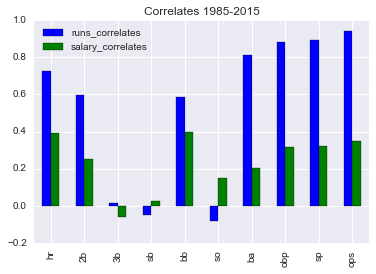

In [135]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
correlates = pd.DataFrame(dict(salary_correlates=salary_correlates, runs_correlates=runs_correlates))
correlates.plot.bar(title='Correlates 1985-2015')

Looking at the data above, it looks like teams are doing a pretty good job of paying for the right batter attributes.  However, OPS has the highest correlation with runs, but has the third highest correlation with salaries.  Homeruns and walks have the highest correlation with salaries, and are also highly correlated with runs.  It seems that during the time period, teams may have been valuing homeruns and walks highest - whereas, all else being equal, it would make more sense to value OPS higher.  It is important to note that over this time period, teams began applying data science to roster formation.  It is very possible that the data from a more recent time period may show teams valuing OPS highest.  I'll investigate that next.

In [136]:
#create columns identifying players whose salary and ops,salary and hr, salary and bb 
#are above average.  If teams have began paying more for these var
bat_sal_everyday_df['sal&ops'] =(bat_sal_everyday_df['salary_x'] >= bat_sal_everyday_df['salary_y']) & (bat_sal_everyday_df['OPS_x'] >= bat_sal_everyday_df['OPS_y']) 
bat_sal_everyday_df['sal&hr'] = (bat_sal_everyday_df['salary_x'] >= bat_sal_everyday_df['salary_y']) & (bat_sal_everyday_df['HR_x'] >= bat_sal_everyday_df['HR_y'])
bat_sal_everyday_df['sal&bb'] = (bat_sal_everyday_df['salary_x'] >= bat_sal_everyday_df['salary_y']) & (bat_sal_everyday_df['BB_x'] >= bat_sal_everyday_df['BB_y'])

#group by year
yearly_bat_sal = bat_sal_everyday_df.groupby('yearID').sum()

yearly_comp_df = pd.DataFrame(dict(sal_and_ops=yearly_bat_sal['sal&ops'],sal_and_hr=yearly_bat_sal['sal&hr'],sal_and_bb=yearly_bat_sal['sal&bb']))


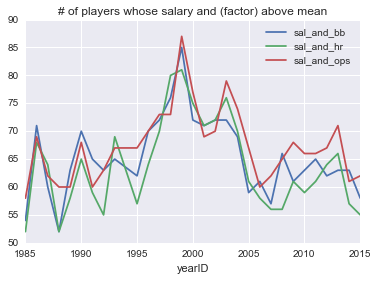

In [137]:
#examine trend over time
yearly_comp_df.plot(title='# of players whose salary and (factor) above mean' )

It appears that there is no significant increase in the number of players who have both above average salaries and an above average OPS, from 1985 to 2015. I will check to see if there is any trend in the number of players who are at least 1 standard deviation above the mean in the above categories categories. There was a pretty large jump in the middle for all three categories.  This increase could be incidental, but it looks like something may be going on. It does look like this rise occured during the peak of steroids in baseball.  This may be something else to evaluate later.

Try looking at 1 standard dev above for both sal and other factors.  Use apply(standardize(df)).

In [138]:
#create columns identifying players whose real salary and ops,real salary and hr, real salary and bb 
#are both 1 standard deviation above the mean.  If teams have began paying more for these var
bat_sal_everyday_df['sal&ops'] =(standardize(bat_sal_everyday_df['sal_real']) >= 1) & (standardize(bat_sal_everyday_df['OPS_x']) >= 1) 
bat_sal_everyday_df['sal&hr'] = (standardize(bat_sal_everyday_df['sal_real']) >= 1) & (standardize(bat_sal_everyday_df['HR_x']) >= 1)
bat_sal_everyday_df['sal&bb'] = (standardize(bat_sal_everyday_df['sal_real']) >= 1) & (standardize(bat_sal_everyday_df['BB_x']) >= 1)

#group by year
yearly_bat_sal = bat_sal_everyday_df.groupby('yearID').sum()

yearly_comp_one_stdev_df = pd.DataFrame(dict(sal_and_ops=yearly_bat_sal['sal&ops'],sal_and_hr=yearly_bat_sal['sal&hr'],sal_and_bb=yearly_bat_sal['sal&bb']))

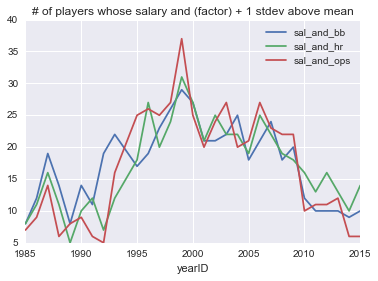

In [139]:
#examine trend over time
yearly_comp_one_stdev_df.plot(title='# of players whose salary and (factor) + 1 stdev above mean')

It doesn't appear that there is any significant difference in the relationship between OPS and salary now (2015) and 1985.  This suggests that teams may not be acting rationally when it comes to constructing their rosters and paying players.  Of course there could be other factors that are causing this relationship to appear unchanged.  There are surely several other factors that we haven't examined here that drive players salaries.  If these others factors were included, we may find that teams are acting completely rationally in regard to what they are buying in players.  This analysis is limited, so it's important not to draw strong conclusions either way.  There are also problems with the data, such as missing values.  I also did not perform any statistical test on the variables, so I can't say that the difference is not statistically significant.

I am still curious what caused the rise and decline in the 1990s and 2000s.  I suspect that steroids may be a contributing factor. I'm going to look at homerun data throught baseball history to see if anything sticks out.

In [148]:
batting_all_df['HR/AB']=batting_all_df['HR']/batting_all_df['AB']
batting_yearly_df = batting_all_df.groupby('yearID').mean()

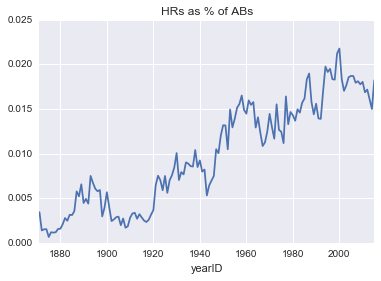

In [149]:
batting_yearly_df['HR/AB'].plot(title='HRs as % of ABs')

It looks like homeruns per at bat began to plateau around 1960, then rose sharply around 1990, before falling in the mid 2000s.  The MLB first implemented a steroid testing policy in 2004, so this timeline would make since.  Reference on steroid policy timeline: http://www.usatoday.com/story/sports/mlb/2014/03/28/a-timeline-of-mlbs-drug-testing-rules/7024351/

Let's conduct an independent t-test to see if there is any statistically significant difference between homeruns per at bat in 2000 and 2015.  The test will be two-tailed and will be done at the 95% confidence level.  H0: no difference in hr/ab between 2000 and 2015; 
HA: difference in hr/ab between 2000 and 2015.

In [150]:
#slice the df to show just data from each of the two years
batting_2000_df = batting_all_df[batting_all_df['yearID']==2000]
batting_2015_df = batting_all_df[batting_all_df['yearID']==2015]

In [151]:
#look only at data for players who had at least 200 at bats
#so data is mostly comprised of everyday players
batting_2000_df = batting_2000_df[batting_2000_df['AB']>=200]
batting_2015_df = batting_2015_df[batting_2015_df['AB']>=200]

In [152]:
def t_stat(mean1,mean2,se):
    return (mean1-mean2)/se

In [153]:
mean_hr_ab_2000 = batting_2000_df['HR/AB'].mean()
mean_hr_ab_2015 = batting_2015_df['HR/AB'].mean()
se_hr_ab_2000_2015 = sqrt((batting_2000_df['HR/AB'].var()/len(batting_2000_df['HR/AB']))+(batting_2015_df['HR/AB'].var()/len(batting_2015_df['HR/AB'])))

In [154]:
t_stat(mean_hr_ab_2000,mean_hr_ab_2015,se_hr_ab_2000_2015)

3.2295230881826504

In [155]:
df = len(batting_2000_df['HR/AB'])+len(batting_2015_df['HR/AB'])-2
df

638

I entered the t stat and df above into this calculator: http://www.graphpad.com/quickcalcs/pValue2/
and returned a p-value of 0.0013.  This indicates a statistically significant difference in hr/ab between the two years.  This doesn't necessarily mean that steroids caused the difference.  Instead, it indicates that there is only a 0.13% probability that this was merely caused by chance.  Again, this analysis looks at limited data, so we can't draw definitive conclusions.